In [2]:
# Load require modules
import numpy as np
import gcsfs
import pandas as pd
import xarray as xr
import warnings
import matplotlib.pyplot as plt
import intake
import xesmf as xe
%matplotlib inline
import cartopy
from cartopy import util
import cartopy.crs as ccrs
import zarr
import dask.array as da  
from dask.diagnostics import ProgressBar
from tqdm.autonotebook import tqdm
import nc_time_axis
import time

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

In [3]:
#cat_url = "/space/hall4/sitestore/eccc/crd/CMIP6/final/canesm_final.json"
# panego data catalogue on Google Cloud
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)

In [5]:
# Create a dictionary of dictionaries containing the data for historical and tier 1 SSP experiments.
# Note we only load member r1i1p1f1
dset_dicts={}
experiment_ids=['historical', 'ssp119','ssp126', 'ssp245', 'ssp370', 'ssp585']

for exp in experiment_ids:
    query = dict(table_id=['Omon'], 
                 variable_id=['friver'],
                 source_id='CanESM5',
              experiment_id='historical', member_id='r1i1p1f1')
    cat = col.search(**query)
    dset_dicts[exp] = cat.to_dataset_dict(zarr_kwargs={'consolidated': True}, 
                                        storage_options={'token': 'anon'})

/tmp/ncs001/1806153/ipykernel_2991851/3861660030.py:12: UserWarning: There are no datasets to load! Returning an empty dictionary.
  dset_dicts[exp] = cat.to_dataset_dict(zarr_kwargs={'consolidated': True},
/tmp/ncs001/1806153/ipykernel_2991851/3861660030.py:12: UserWarning: There are no datasets to load! Returning an empty dictionary.
  dset_dicts[exp] = cat.to_dataset_dict(zarr_kwargs={'consolidated': True},
/tmp/ncs001/1806153/ipykernel_2991851/3861660030.py:12: UserWarning: There are no datasets to load! Returning an empty dictionary.
  dset_dicts[exp] = cat.to_dataset_dict(zarr_kwargs={'consolidated': True},
/tmp/ncs001/1806153/ipykernel_2991851/3861660030.py:12: UserWarning: There are no datasets to load! Returning an empty dictionary.
  dset_dicts[exp] = cat.to_dataset_dict(zarr_kwargs={'consolidated': True},
/tmp/ncs001/1806153/ipykernel_2991851/3861660030.py:12: UserWarning: There are no datasets to load! Returning an empty dictionary.
  dset_dicts[exp] = cat.to_dataset_dict(z

In [71]:
ds_friver_his = xr.open_dataset('~scrd106/model_output/CMIP6/final/CMIP6/CMIP/CCCma/CanESM5/historical/r1i1p1f1/Omon/friver/gn/v20190429/friver_Omon_CanESM5_historical_r1i1p1f1_gn_185001-201412.nc')
ds_friver_ghg = xr.open_dataset('/home/scrd106/model_output/CMIP6/final/CMIP6/DAMIP/CCCma/CanESM5/hist-GHG/r1i1p1f1/Omon/friver/gn/v20190429/friver_Omon_CanESM5_hist-GHG_r1i1p1f1_gn_185001-202012.nc')
ds_friver_so3 = xr.open_dataset('/home/scrd106/model_output/CMIP6/final/CMIP6/DAMIP/CCCma/CanESM5/hist-stratO3/r1i1p1f1/Omon/friver/gn/v20190429/friver_Omon_CanESM5_hist-stratO3_r1i1p1f1_gn_185001-202012.nc')
ds_friver_nat = xr.open_dataset('/home/scrd106/model_output/CMIP6/final/CMIP6/DAMIP/CCCma/CanESM5/hist-nat/r1i1p1f1/Omon/friver/gn/v20190429/friver_Omon_CanESM5_hist-nat_r1i1p1f1_gn_185001-202012.nc')
ds_friver_aer = xr.open_dataset('/home/scrd106/model_output/CMIP6/final/CMIP6/DAMIP/CCCma/CanESM5/hist-aer/r1i1p1f1/Omon/friver/gn/v20190429/friver_Omon_CanESM5_hist-aer_r1i1p1f1_gn_185001-202012.nc')
ds_aco_canesm5 = xr.open_dataset('~scrd106/model_output/CMIP6/final/CMIP6/CMIP/CCCma/CanESM5/historical/r1i1p2f1/Ofx/areacello/gn/v20190429/areacello_Ofx_CanESM5_historical_r1i1p2f1_gn.nc')

In [63]:
ls /home/scrd106/model_output/CMIP6/final/CMIP6/DAMIP/CCCma/CanESM5/

hist-aer/        hist-nat-cmip5/  ssp245-cov-aer/       ssp245-GHG/
hist-aer-cmip5/  hist-sol/        ssp245-cov-fossil/    ssp245-nat/
hist-CO2/        hist-stratO3/    ssp245-cov-GHG/       ssp245-stratO3/
hist-GHG/        hist-totalO3/    ssp245-covid/
hist-GHG-cmip5/  hist-volc/       ssp245-cov-modgreen/
hist-nat/        ssp245-aer/      ssp245-cov-strgreen/


In [59]:
sec2yr=60*60*24*365
def integrate_ar(areacello, friver):
    ant_runoff = (friver * areacello).isel(j=slice(0,50)).sum(dim=['i', 'j'])*sec2yr/1e12
    return ant_runoff

In [72]:
ant_runoff_his = integrate_ar(ds_aco_canesm5.areacello, ds_friver_his.friver)
ant_runoff_ghg = integrate_ar(ds_aco_canesm5.areacello, ds_friver_ghg.friver)
ant_runoff_so3 = integrate_ar(ds_aco_canesm5.areacello, ds_friver_so3.friver)
ant_runoff_nat = integrate_ar(ds_aco_canesm5.areacello, ds_friver_nat.friver)
ant_runoff_aer = integrate_ar(ds_aco_canesm5.areacello, ds_friver_aer.friver)

Text(0, 0.5, 'Antarctic runoff (Gt/yr)')

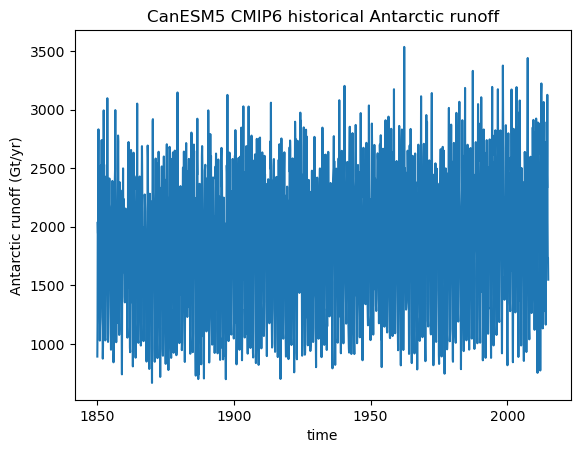

In [43]:
ant_runoff_his.plot()
plt.title('CanESM5 CMIP6 historical Antarctic runoff')
plt.ylabel('Antarctic runoff (Gt/yr)')

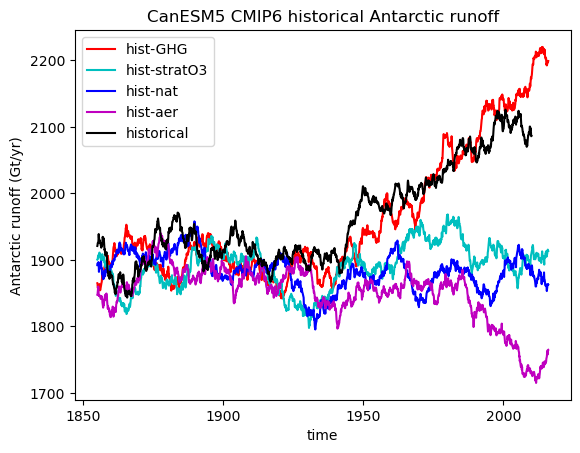

In [75]:
ant_runoff_ghg.rolling(time=120, center='True').mean().plot(color='r', label='hist-GHG')
ant_runoff_so3.rolling(time=120, center='True').mean().plot(color='c', label='hist-stratO3')
ant_runoff_nat.rolling(time=120, center='True').mean().plot(color='b', label='hist-nat')
ant_runoff_aer.rolling(time=120, center='True').mean().plot(color='m', label='hist-aer')
ant_runoff_his.rolling(time=120, center='True').mean().plot(color='k', label='historical')

plt.title('CanESM5 CMIP6 historical Antarctic runoff')
plt.ylabel('Antarctic runoff (Gt/yr)')
plt.legend()

In [38]:
ant_runoff.sel(time=slice('1981','2000')).mean()

<xarray.DataArray ()>
array(2017.93360837)

Text(0, 0.5, 'Antarctic runoff (Gt/yr)')

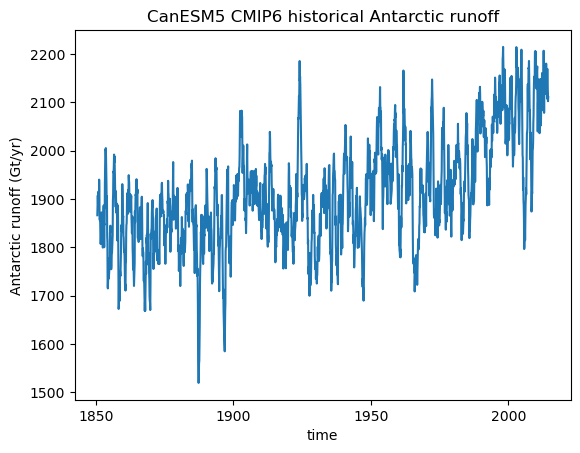

In [39]:
ant_runoff.rolling(time=12, center='True').mean().plot()
plt.title('CanESM5 CMIP6 historical Antarctic runoff')
plt.ylabel('Antarctic runoff (Gt/yr)')